In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Introduction

In this notebook I will intially perform some feature engineering followed by the creation and refinement of a model that will be used to to predict the price of mens shoes from 5 different fashion ecommerce sites. I will look at multiple models and ensembles to find the model that can predict the r2 score the best as this is my target metric. I would like to achieve an r2 value of over 0.7. This notebook follows on from the notebook ***Text_EDA.ipynb*** where intially EDA is performed on the data (which has been scrapped from the relevant websites, this is completed in ***Web_Scraping.ipynb***.

All of the data collected is in the form of words, with the exception of the price which will be used as the target variable. The brand labels and retailers will be treated as binary varibles as all of this data is both important to determine the price of the shoe as well as provide an insight into their relative value (which should have some similarity to the EDA). I will take the most common words from the description test and perform again apply binary values, the number of descriptive words I use will be chosen based on the impact to the model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_val_predict,train_test_split
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV,RidgeCV,Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error
% matplotlib inline

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
## Connect to local database
engine=create_engine('postgresql://localhost:5432/capstone_project')
Data=pd.read_sql_table('mens_shoes_cleaned',con=engine)

In [4]:
## Preview of the data scraped from the retail websites.
Data.head(2)

,id,brand,retailer,description,image_url,image_url_alt,price,date,type_1,type_2
0,728,alexander mcqueen,Matches_Fashion,raised sole hightops leather trainers,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,395.0,2016-11-22,hightops,trainers
1,729,armando cabral,Matches_Fashion,lace up leather derby shoes,http://assetsprx.matchesfashion.com/img/produc...,http://assetsprx.matchesfashion.com/img/produc...,405.0,2016-11-22,derby,lace


In [5]:
## Drop un-necessary columns
Data=Data.drop(['id','image_url','image_url_alt','date','type_1','type_2'],axis=1)

In [6]:
Data.head()

,brand,retailer,description,price
0,alexander mcqueen,Matches_Fashion,raised sole hightops leather trainers,395.0
1,armando cabral,Matches_Fashion,lace up leather derby shoes,405.0
2,bottega veneta,Matches_Fashion,intrecciato leather loafers,380.0
3,armando cabral,Matches_Fashion,lizard effect leather ankle boots,530.0
4,burberry,Matches_Fashion,owen tread sole canvas boots,350.0


## Feature Engineering

In [7]:
## Creating Dummies for the brands and retailers
Data=pd.get_dummies(data=Data,columns=['brand','retailer'])

### Analysis on optimum Count Vectoriser Feature Limit

I will complete a quick analysis in order to find the optimimum Feature limit for the count vectorisor tool. To do so I will run a Random Forest model, with a range of feature sets from 250 to 1250 features from the countvectorizer function. I expect this will provide an increasing r2 score, how ever the behaviour should form an elbow curve, where a increase in features does not provide a signficant increase in r2 when compared to the computation time increases.

In [74]:
Xs=[]
R2s=[]
CVR2s=[]
for x in range(250,1251,250):
    CV=CountVectorizer(stop_words='english',max_features=x)
    CV_model=CV.fit(Data.description)
    CV_Out=CV.fit_transform(Data.description).toarray()
    CV_Out=pd.DataFrame(data=CV_Out,columns=CV_model.get_feature_names())
    df_test=pd.merge(Data,CV_Out,left_index=True,right_index=True)
    
    Data_Red=df_test[df_test.price<2000]
    
    X=Data_Red.drop(['price','description'],axis=1)
    y=Data_Red.price
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
    
    Rft=RandomForestRegressor(n_estimators=100)
    print X_train.shape
    Rft_model=Rft.fit(X_train,y_train)
    print '----------'
    print 'CV:',x
    print "Model Score:", Rft_model.score(X_train,y_train)
    y_pred_Rft=Rft_model.predict(X_test)
    CV=np.mean(cross_val_score(Rft,X_train,y_train,cv=5))
    print "Cross-Val-Score",CV
    print "Test Score:",r2_score(y_test,y_pred_Rft)
    
    Xs.append(x)
    R2s.append(r2_score(y_test,y_pred_Rft))
    CVR2s.append(CV)

(7783, 371)
----------
CV: 250
Model Score: 0.89683330541
Cross-Val-Score 0.709339552114
Test Score: 0.745257016249
(7783, 621)
----------
CV: 500
Model Score: 0.910228716314
Cross-Val-Score 0.718729250807
Test Score: 0.73992791854
(7783, 871)
----------
CV: 750
Model Score: 0.913584731152
Cross-Val-Score 0.723619326182
Test Score: 0.74572724721
(7783, 1121)
----------
CV: 1000
Model Score: 0.915596990924
Cross-Val-Score 0.724932509295
Test Score: 0.743056845059
(7783, 1371)
----------
CV: 1250
Model Score: 0.916865818168
Cross-Val-Score 0.728329041158
Test Score: 0.742182046763


In [4]:
Xs=[250,500,750,1000,1250]
R2s=[0.89683330541,0.910228716314,0.913584731152,0.915596990924,0.916865818168]
CVR2s=[0.709339552114,0.718729250807,0.723619326182,0.724932509295,0.728329041158]

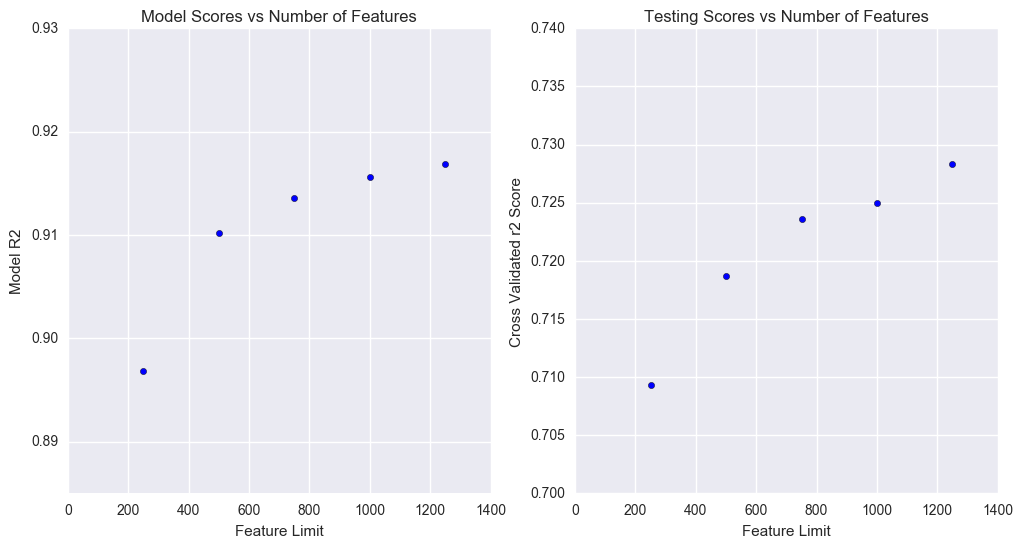

In [7]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.scatter(x=Xs,y=R2s)
ax2.scatter(x=Xs,y=CVR2s)
ax1.set_title('Model Scores vs Number of Features')
ax2.set_title('Testing Scores vs Number of Features')
ax1.set_xlabel('Feature Limit')
ax2.set_xlabel('Feature Limit')
ax1.set_ylabel('Model R2')
ax2.set_ylabel('Cross Validated r2 Score')

From the chart above we can see that  the training r2 score and the cross validated r2 scores keep increaseing with the addition of more features, how ever this does lead to a substantially larger calualtion time and increased model complexity which is likely to result in overfitting (this can be seen by a reduction in Test Score. I will there use a feature limit of 750, around where the elbow appears in the chart, this should give me the benefit of additional features to produce a more accurate result, without overfitting or generating too long calculation times.

In [8]:
CV=CountVectorizer(stop_words='english',max_features=750)
CV_model=CV.fit(Data.description)
CV_Out=CV.fit_transform(Data.description).toarray()
CV_Out=pd.DataFrame(data=CV_Out,columns=CV_model.get_feature_names())

In [9]:
df=pd.merge(Data,CV_Out,left_index=True,right_index=True)

In [10]:
df=df.drop('description',axis=1)

In [11]:
df.head()

,price,brand_a diciannoveventitre,brand_a. testoni,brand_adidas,brand_adidas by raf simons,brand_alberto fasciani,brand_alexander mcqueen,brand_ami alexandre mattiussi,brand_android homme,brand_ann demeulemeester,...,xxx,yohji,zak,zerogrand,zg,zip,zipped,zipper,zoom,zx
0,395.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,405.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Test Train Split and Base Model

I will now create a base model to examine the prelimiary ouput of the predicted data, this will allow me to identify any outliers that may be having an adverse affect on the model coefficents. I will use a test size of 25% and a base Lasso CV model.

In [ ]:
X=df.drop('price',axis=1)

In [ ]:
y=df.price

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [101]:
LM=LassoCV()
model=LM.fit(X_train,y_train)
print 'Training R2:',model.score(X_train,y_train)
y_pred=model.predict(X_test)
print 'R2:',r2_score(y_test,y_pred)
print 'MSE:',mean_squared_error(y_test,y_pred)

Training R2: 0.704888790487
R2: 0.560538473527
MSE: 41712.8937059


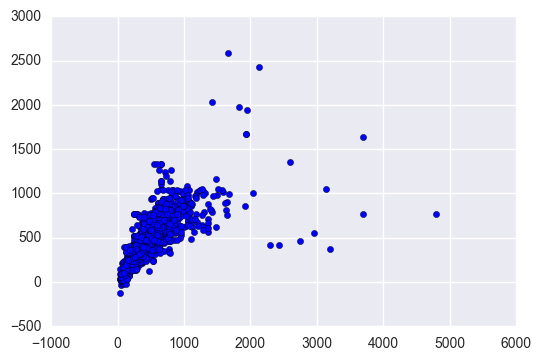

In [102]:
plt.scatter(y_test,y_pred)

### Outlier Reduction
From the chart above it is noticible that there is a very large spread in the data where prices are above £2000 and the model is struggling to predict this with any accuracy. I will remove all of the data points where the valuations are above £2000 as I feel these shoes are few and far between but are skewing the data significantly. Once these data points are removed there should be a noticible drop in MSE and an increase in R2.

In [12]:
Low_Cost_Data=df[df.price<2000]

In [13]:
X=Low_Cost_Data.drop(['price'],axis=1)
y=Low_Cost_Data.price

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [15]:
def ploty(Test,Predicted):
    plt.scatter(Test,Predicted)
    plt.xlim(-200,2000)
    plt.ylim(-200,2000)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values')

In [78]:
R2_Scores=[]
MSE_Scores=[]
Train_R2_Scores=[]
Model=[]

## All Models

### Lasso

In [81]:
Las=LassoCV()
las_model=Las.fit(X_train,y_train)

print'Training R2:',las_model.score(X_train,y_train)
Train_R2_Scores.append(las_model.score(X_train,y_train))

tra_y_pred_las=las_model.predict(X_train)
y_pred_las=las_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_las)
R2_Scores.append(r2_score(y_test,y_pred_las))
print 'MSE:',mean_squared_error(y_test,y_pred_las)
MSE_Scores.append(mean_squared_error(y_test,y_pred_las))
Model.append('Lasso')

Training R2: 0.776837865355
R2: 0.75458264023
MSE: 14875.1175616


In [139]:
las_model.alpha_

0.030596972501600473

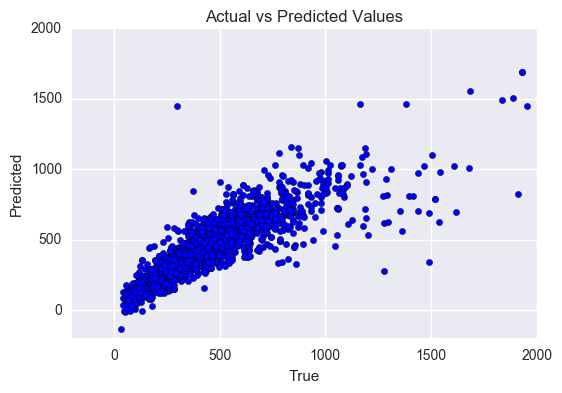

In [84]:
ploty(y_test,y_pred_las)

The Lasso model has produced quite a strong r2 score and the MSE has been significantly reduced with the removal of the data points over £2000. It is clear that there is a bit of under valuation on all shoes over ~£1000, it will be interesting if any of the models have a contrasting behaviour that could be used in an ensemble to counter balance this pattern. Again the majority of outliers are found at the higher end of the spectrium >£1000, and there is a number of results that are lower then 0 which will need to rectified either with an ensemble or a manual rule.

### Ridge

In [85]:
Rid=RidgeCV()
Rid_model=Rid.fit(X_train,y_train)

print 'Training R2:',Rid_model.score(X_train,y_train)
Train_R2_Scores.append(Rid_model.score(X_train,y_train))

tra_y_pred_Rid=Rid_model.predict(X_train)
y_pred_Rid=Rid_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_Rid)
R2_Scores.append(r2_score(y_test,y_pred_Rid))
print 'MSE:',mean_squared_error(y_test,y_pred_Rid)
MSE_Scores.append(mean_squared_error(y_test,y_pred_Rid))
Model.append('Ridge')

Training R2: 0.789431552982
R2: 0.761887034718
MSE: 14432.3871581


In [161]:
Rid_model.alpha_

1.0

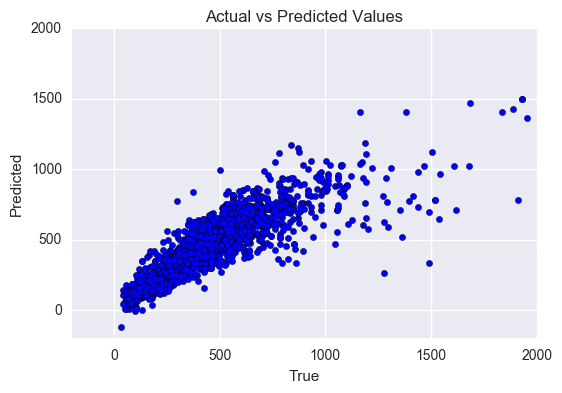

In [86]:
ploty(y_test,y_pred_Rid)

The Ridge model performs a bit better then the Lasso model, however it has similar problems with low priced shoes and those over the value of 1000.

### Support Vector Regressor

In [87]:
svr=SVR(kernel='linear')
svr_model=svr.fit(X_train,y_train)

print 'Training R2:',svr_model.score(X_train,y_train)
Train_R2_Scores.append(svr_model.score(X_train,y_train))

tra_y_pred_svr=svr_model.predict(X_train)
y_pred_svr=svr_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_svr)
R2_Scores.append(r2_score(y_test,y_pred_svr))
print 'MSE:',mean_squared_error(y_test,y_pred_svr)
MSE_Scores.append(mean_squared_error(y_test,y_pred_svr))
Model.append('SVR')

Training R2: 0.360820135381
R2: 0.339112575836
MSE: 40057.3868884


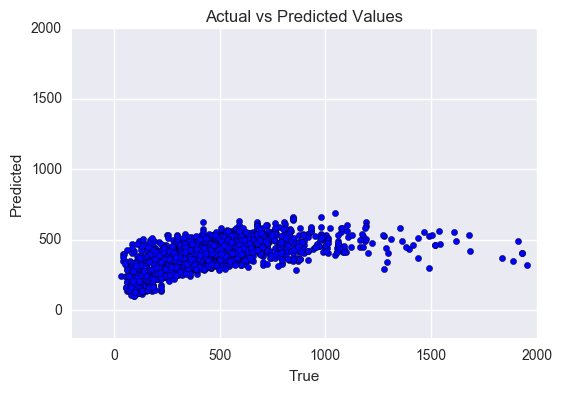

In [88]:
ploty(y_test,y_pred_svr)

The support vector model has performed very poorly with this dataset, I have also tried using a kbf kernel which resulted in worse results. Again the model is significantly undervaluing the majority of shoes, but this is far worse then in the Linear Models with regulisation.

### Random Forest

In [89]:
Rft=RandomForestRegressor(n_estimators=100)
Rft_model=Rft.fit(X_train,y_train)

print 'Training R2:',Rft_model.score(X_train,y_train)
Train_R2_Scores.append(Rft_model.score(X_train,y_train))

tra_y_pred_Rft=Rft_model.predict(X_train)
y_pred_Rft=Rft_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_Rft)
R2_Scores.append(r2_score(y_test,y_pred_Rft))
print 'MSE:',mean_squared_error(y_test,y_pred_Rft)
MSE_Scores.append(mean_squared_error(y_test,y_pred_Rft))
Model.append('Random Forest')

Training R2: 0.917240899121
R2: 0.743857383566
MSE: 15525.1915984


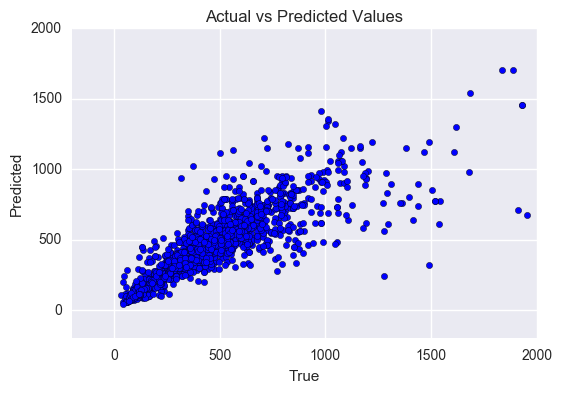

In [90]:
ploty(y_test,y_pred_Rft)

The Random Forest model performed extremely well in the training set, however not as well in the test set. Overfitting is a common trait of tree ensembles so using a Grid Search and cross validating the results should be very beneficial. The Random Forest model does not produce any values that are below zero, and does over values some shoes below £1000, however as with the previous models it undervalues most shoes prived above ~£1250.

### Gradient Boosting

In [91]:
Gra=GradientBoostingRegressor()
Gra_model=Gra.fit(X_train,y_train)
print 'Training R2:',Gra_model.score(X_train,y_train)
Train_R2_Scores.append(Gra_model.score(X_train,y_train))

tra_y_pred_Gra=Gra_model.predict(X_train)
y_pred_Gra=Gra_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_Gra)
R2_Scores.append(r2_score(y_test,y_pred_Gra))
print 'MSE:',mean_squared_error(y_test,y_pred_Gra)
MSE_Scores.append(mean_squared_error(y_test,y_pred_Gra))
Model.append('Gradient Boost')

Training R2: 0.542321824928
R2: 0.53296986207
MSE: 28307.4034088


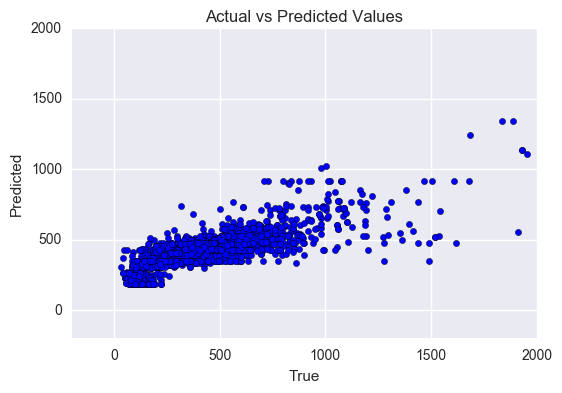

In [92]:
ploty(y_test,y_pred_Gra)

The Gradient boosting model performs in a simlar way to the SVR model, however with a slightly improved performance, the predicted values below £500 tend to be over valued where as thise above £1000 are all undervalued, I expect the peformance of the Gradient boosting will be improved with optimised hyperparameters.

### K-Nearest Neighbours

In [93]:
knn=KNeighborsRegressor()
knn_model=knn.fit(X_train,y_train)

print 'Training R2:',knn_model.score(X_train,y_train)
Train_R2_Scores.append(knn_model.score(X_train,y_train))

tra_y_pred_knn=knn_model.predict(X_train)
y_pred_knn=knn_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_knn)
R2_Scores.append(r2_score(y_test,y_pred_knn))
print 'MSE:',mean_squared_error(y_test,y_pred_knn)
MSE_Scores.append(mean_squared_error(y_test,y_pred_knn))
Model.append('KNN')

Training R2: 0.739527232629
R2: 0.611493915221
MSE: 23547.9417182


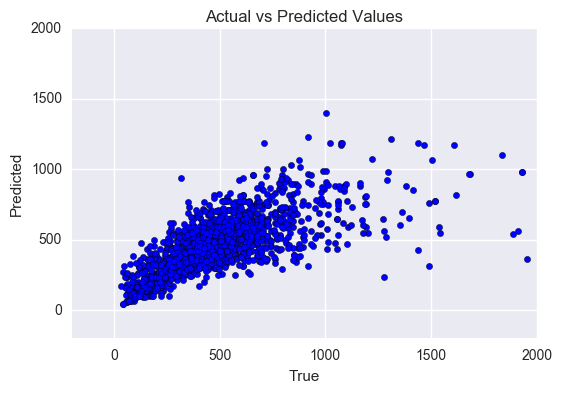

In [94]:
ploty(y_test,y_pred_knn)

The KNN model produces a similar behaviour as the Random Forest model, but at a much lower level. Again values tend to be under-estimated over the £1000 point.

 ### XG-Boost

In [95]:
xgb=XGBRegressor()
xgb_model=xgb.fit(X_train,y_train)

print 'Training R2:',xgb_model.score(X_train,y_train)
Train_R2_Scores.append(xgb_model.score(X_train,y_train))

tra_y_pred_xgb=xgb_model.predict(X_train)
y_pred_xgb=xgb_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_xgb)
R2_Scores.append(r2_score(y_test,y_pred_xgb))
print 'MSE:',mean_squared_error(y_test,y_pred_xgb)
MSE_Scores.append(mean_squared_error(y_test,y_pred_xgb))
Model.append('XGB')

Training R2: 0.529010764111
R2: 0.516176759568
MSE: 29325.2587641


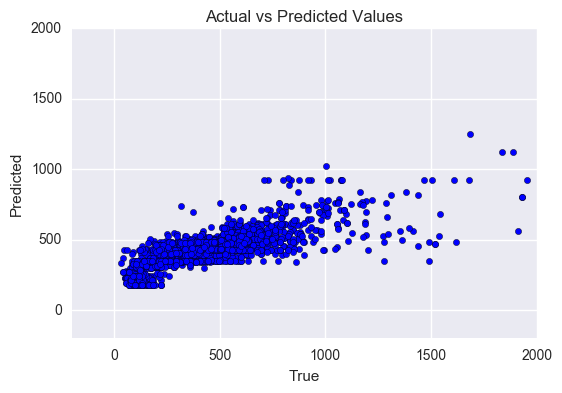

In [96]:
ploty(y_test,y_pred_xgb)

The XG-Boost model solved extremely quickly and behaves similarly to the Gradient Boosting (as that is what the model is based upon), as I do not have that much experience with this model I will not be performing any further optimisation on it, I just wanted to see it implemented, and its base results.

### Ada-Boost

In [97]:
Ada = AdaBoostRegressor()
Ada_model=Ada.fit(X_train,y_train)
tra_y_pred_Ada=Ada_model.predict(X_train)
y_pred_Ada=Ada_model.predict(X_test)
r2=r2_score(y_test,y_pred_Ada)
print 'Training R2:',Ada_model.score(X_train,y_train)
Train_R2_Scores.append(Ada_model.score(X_train,y_train))
print 'R2:',r2_score(y_test,y_pred_Ada)
R2_Scores.append(r2_score(y_test,y_pred_Ada))
print 'MSE:',mean_squared_error(y_test,y_pred_Ada)
MSE_Scores.append(mean_squared_error(y_test,y_pred_Ada))
Model.append('Ada Boost')

Training R2: 0.0187630127607
R2: 0.0327390755835
MSE: 58627.1483685


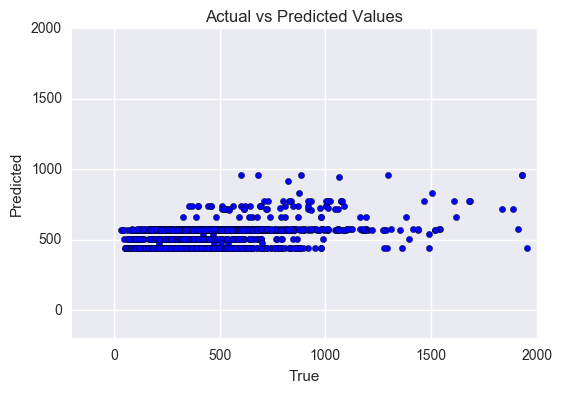

In [98]:
ploty(y_test,y_pred_Ada)

The Ada-Boost model has not performed at all, I will not look further into this at this point, but will perhaps come back to it in the future,

### Extra Trees

In [99]:
ext=ExtraTreesRegressor(n_estimators=100)
ext_model=ext.fit(X_train,y_train)

print 'Training R2:',ext_model.score(X_train,y_train)
Train_R2_Scores.append(ext_model.score(X_train,y_train))

tra_y_pred_ext=ext_model.predict(X_train)
y_pred_ext=ext_model.predict(X_test)

print 'R2:',r2_score(y_test,y_pred_ext)
R2_Scores.append(r2_score(y_test,y_pred_ext))
print 'MSE:',mean_squared_error(y_test,y_pred_ext)
MSE_Scores.append(mean_squared_error(y_test,y_pred_ext))
Model.append('Extra Trees')

Training R2: 0.940637090569
R2: 0.682561489601
MSE: 19240.4284896


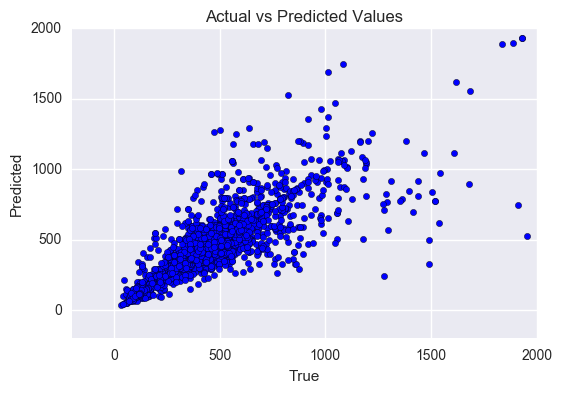

In [100]:
ploty(y_test,y_pred_ext)

The Extra trees model, has performed the best with the training set, but suffers from overfitting. There is a fairly even spread of over-valuation and under-valuation comparitive to the other models.

## Initial Model Scores and Summary

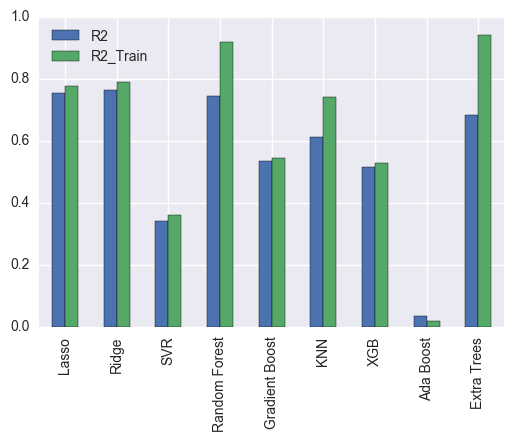

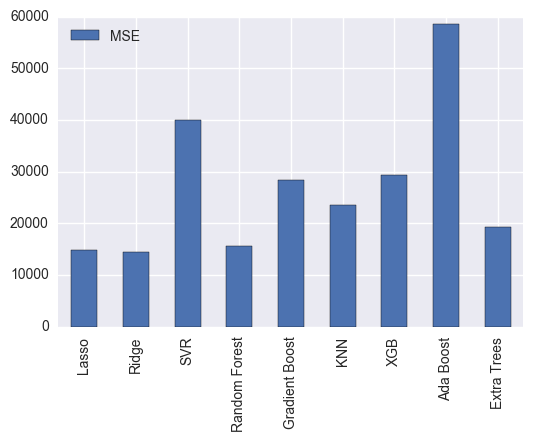

In [111]:
Ini_Mod_Scores=pd.DataFrame(index=Model,data={'R2':R2_Scores,'MSE':MSE_Scores,'R2_Train':Train_R2_Scores})
Ini_Mod_Scores.drop('MSE',axis=1).plot(kind='bar')
Ini_Mod_Scores.drop(['R2','R2_Train'],axis=1).plot(kind='bar')

From the plots above it is clear that the linear models and the tree ensembles are performing the best, with Extra Trees and Random Forest suffering from overfitting as would have been expected. The models also perform similarly when comparing MSE, meaning that there are no signifcant outliers caused by individual models.

### Combination of Random Forest, Ridge, Extra Trees and Lasso

I will now create a few ensembles of the results of the different models to see I can improve on the base scores. THe first ensemble will be a manual ensemble, of the 4 best models (Lasso, Ridge, Random Forest and Extra Trees), I will simply calculate the mean result from the four models.

In [112]:
print r2_score(y_train,((tra_y_pred_Rft+tra_y_pred_las+tra_y_pred_Rid+tra_y_pred_ext)/4))
print r2_score(y_test,((y_pred_Rft+y_pred_las+y_pred_Rid+y_pred_ext)/4))

0.889596139392
0.776225216551


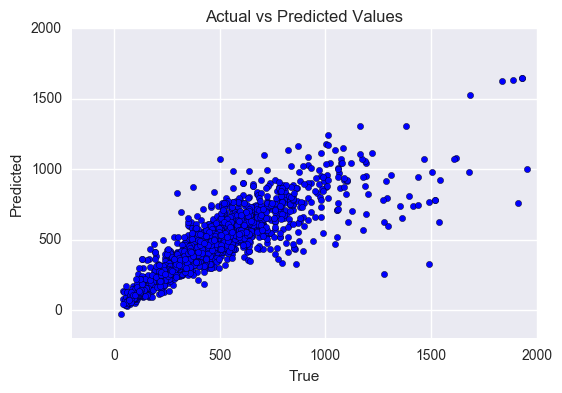

In [113]:
ploty(y_test,((y_pred_Rft+y_pred_las+y_pred_Rid+y_pred_ext)/4))

This manual ensemble has a lower training score then the two tree based models however produces the best test score so far. There are still  some predicted values below zero how ever there seems to be less.

### Ensemble of Models

In [114]:
X_Y_Pred=pd.DataFrame({'Lasso':tra_y_pred_las,
                       'Ridge':tra_y_pred_Rid,
                       'Ada':tra_y_pred_Ada,
                       'Random':tra_y_pred_Rft,
                       'Ext':tra_y_pred_ext,
                       'XGB':tra_y_pred_xgb,
                       'Grad':tra_y_pred_Gra,
                       'KNN':tra_y_pred_knn})

In [115]:
X_Y_Test=pd.DataFrame({'Lasso':y_pred_las,
                       'Ridge':y_pred_Rid,
                       'Ada':y_pred_Ada,
                       'Random':y_pred_Rft,
                       'Ext':y_pred_ext,
                       'XGB':y_pred_xgb,
                       'Grad':y_pred_Gra,
                       'KNN':y_pred_knn})

### Ridge Ensemble of Lasso, Ridge, Random Forest and Extra Trees

In [116]:
Rid_cum=RidgeCV()
Rid_cum_model=Rid_cum.fit(X_Y_Pred[['Lasso','Ridge','Random','Ext']],y_train)
print 'Training R2:',Rid_cum_model.score(X_Y_Pred[['Lasso','Ridge','Random','Ext']],y_train)
y_pred_Rid_cum=Rid_cum_model.predict(X_Y_Test[['Lasso','Ridge','Random','Ext']])
print 'R2:',r2_score(y_test,y_pred_Rid_cum)
print 'MSE:',mean_squared_error(y_test,y_pred_Rid_cum)

Training R2: 0.940637090569
R2: 0.682561595126
MSE: 19240.4220936


In [117]:
Rid_cum_model.coef_

array([ -3.21648258e-07,   1.36729795e-07,   1.39046460e-06,
         9.99998849e-01])

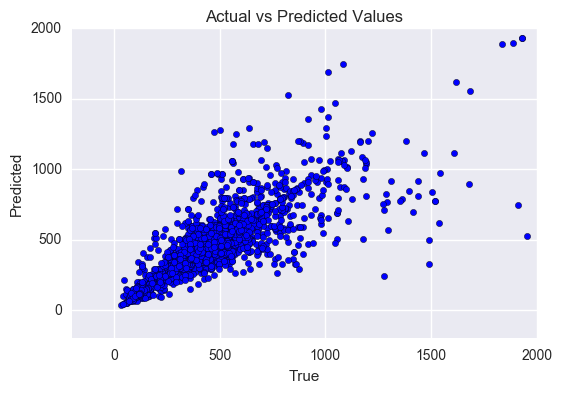

In [118]:
ploty(y_test,y_pred_Rid_cum)

From the coefficents we can see that the Ridge ensemble of the 4 best models essentially takes the data from the Extra Trees models, with negligible coefficients for the other three models.

### Lasso Ensemble of all Models

In [119]:
Las_cum=LassoCV()
Las_cum_model=Las_cum.fit(X_Y_Pred,y_train)
print 'Training R2:',Las_cum_model.score(X_Y_Pred,y_train)
y_pred_Las_cum=Las_cum_model.predict(X_Y_Test)
print 'R2:',r2_score(y_test,y_pred_Las_cum)
print 'MSE:',mean_squared_error(y_test,y_pred_Las_cum)

Training R2: 0.940632724518
R2: 0.683023626406
MSE: 19212.4176785


In [120]:
Las_cum_model.coef_

array([ 0.        ,  0.99784557,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

Again the Lasso ensemble only uses data from the Extra Trees model.

### Random Forest Ensemble of Lasso, Ridge, Random Forest and Extra Trees

In [121]:
Rft_cum=RandomForestRegressor()
Rft_cum_model=Rft_cum.fit(X_Y_Pred[['Lasso','Ridge','Random','Ext']],y_train)
print 'Training R2:',Rft_cum_model.score(X_Y_Pred[['Lasso','Ridge','Random','Ext']],y_train)
y_pred_Rft_cum=Rft_cum_model.predict(X_Y_Test[['Lasso','Ridge','Random','Ext']])
print 'R2:',r2_score(y_test,y_pred_Rft_cum)
print 'MSE:',mean_squared_error(y_test,y_pred_Rft_cum)

Training R2: 0.939030835734
R2: 0.680466508671
MSE: 19367.4084541


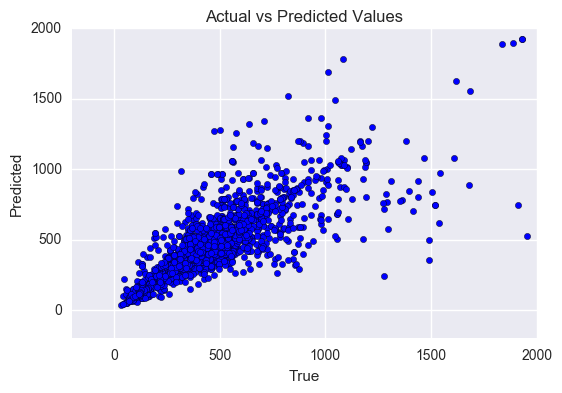

In [122]:
ploty(y_test,y_pred_Rft_cum)

The Random Forest ensemble of the four best models also seems to just output the Extra Trees model.

From the three computed models and 1 manual model I have looked at, the three computed models have just used ata from the Extra trees model and have improved the training r2 slightly however, this seems to be over-fit data as the manual model is the only one that produces an improved r2 score.

## GridSearch

I will now gridsearch each of the models with the exception of XG-Boost, SVR and Ada-Boost the first due to my lack of experience with such a model, and the latter two due to poor intial performace and required processing time.

For the Lasso and Ridge models I will start with a large range of alphas in order to ensure the models do not get caught in a local minima, I will then narrow the search area down to find the optimum value.

### Lasso

In [73]:
from sklearn.linear_model import Lasso
Las=Lasso()
parameters={'alpha':np.logspace(start=-10, stop=10, num=10)}

#After completion, show the final best results and scores
gs_Las = GridSearchCV(Las,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Las.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=1e-10 .....................................................


/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.709478 -   0.0s
[CV] alpha=1e-10 .....................................................
[CV] ............................ alpha=1e-10, score=0.706773 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.4s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.684743 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.4s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.712239 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.706618 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.709478 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.706774 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.684744 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.712240 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.706619 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.709436 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.706967 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.684811 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.712389 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.706737 -   0.0s
[CV] alpha=0.000464158883361 .........................................
[CV] ................ alpha=0.000464158883361, score=0.710523 -   0.0s
[CV] alpha=0.000464158883361 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.66810e-08,   2.78256e-06,   4.64159e-04,
         7.74264e-02,   1.29155e+01,   2.15443e+03,   3.59381e+05,
         5.99484e+07,   1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [74]:
gs_Las.best_params_

{'alpha': 0.077426368268112777}

In [75]:
gs_Las.best_score_

0.71385794413320758

In [125]:
gs_Las.grid_scores_

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.70397, std: 0.00983, params: {'alpha': 1e-10},
 mean: 0.70397, std: 0.00983, params: {'alpha': 1.6681005372000592e-08},
 mean: 0.70407, std: 0.00984, params: {'alpha': 2.782559402207126e-06},
 mean: 0.70578, std: 0.01008, params: {'alpha': 0.00046415888336127822},
 mean: 0.71386, std: 0.01318, params: {'alpha': 0.077426368268112777},
 mean: 0.05453, std: 0.00407, params: {'alpha': 12.915496650148826},
 mean: -0.00058, std: 0.00037, params: {'alpha': 2154.4346900318865},
 mean: -0.00058, std: 0.00037, params: {'alpha': 359381.36638046405},
 mean: -0.00058, std: 0.00037, params: {'alpha': 59948425.031894207},
 mean: -0.00058, std: 0.00037, params: {'alpha': 10000000000.0}]

From the scores we can see there is sharp drop off after an alpha of 0.07, I will therefore concentrate my search around this region.

In [140]:
Las=Lasso()
parameters={'alpha':np.logspace(start=-2, stop=0, num=30)}

#After completion, show the final best results and scores
gs_Las = GridSearchCV(Las,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Las.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] alpha=0.01 ......................................................
[CV] ............................. alpha=0.01, score=0.722798 -   0.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ............................. alpha=0.01, score=0.728606 -   0.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV] ............................. alpha=0.01, score=0.697576 -   0.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.3s remaining:    0.0s


[CV] ............................. alpha=0.01, score=0.730130 -   0.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.9s remaining:    0.0s


[CV] ............................. alpha=0.01, score=0.724069 -   0.0s
[CV] alpha=0.0117210229753 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] .................. alpha=0.0117210229753, score=0.723620 -   0.0s
[CV] alpha=0.0117210229753 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV] .................. alpha=0.0117210229753, score=0.729818 -   0.0s
[CV] alpha=0.0117210229753 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV] .................. alpha=0.0117210229753, score=0.698309 -   0.0s
[CV] alpha=0.0117210229753 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV] .................. alpha=0.0117210229753, score=0.731147 -   0.1s
[CV] alpha=0.0117210229753 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV] .................. alpha=0.0117210229753, score=0.725250 -   0.0s
[CV] alpha=0.0137382379588 ...........................................
[CV] .................. alpha=0.0137382379588, score=0.724374 -   0.0s
[CV] alpha=0.0137382379588 ...........................................
[CV] .................. alpha=0.0137382379588, score=0.731013 -   0.0s
[CV] alpha=0.0137382379588 ...........................................
[CV] .................. alpha=0.0137382379588, score=0.698744 -   0.0s
[CV] alpha=0.0137382379588 ...........................................
[CV] .................. alpha=0.0137382379588, score=0.732109 -   0.0s
[CV] alpha=0.0137382379588 ...........................................
[CV] .................. alpha=0.0137382379588, score=0.726347 -   0.0s
[CV] alpha=0.0161026202756 ...........................................
[CV] .................. alpha=0.0161026202756, score=0.724960 -   0.0s
[CV] alpha=0.0161026202756 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.01   ,  0.01172,  0.01374,  0.0161 ,  0.01887,  0.02212,
        0.02593,  0.03039,  0.03562,  0.04175,  0.04894,  0.05736,
        0.06723,  0.0788 ,  0.09237,  0.10826,  0.1269 ,  0.14874,
        0.17433,  0.20434,  0.2395 ,  0.28072,  0.32903,  0.38566,
        0.45204,  0.52983,  0.62102,  0.7279 ,  0.85317,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [134]:
gs_Las.best_params_

{'alpha': 0.025929437974046669}

In [133]:
gs_Las.best_score_

0.72362154968566861

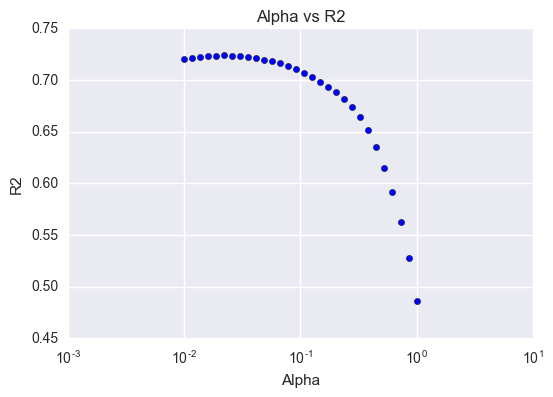

In [176]:
plt.scatter(y=gs_Las.cv_results_['mean_test_score'],x=np.logspace(start=-2, stop=0, num=30))
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.title('Alpha vs R2')

The plot above shows the R2 as alpha is varied in the specified region, there is a clear peak where the best score is found. I could possibly improve on this alpha with a more localised search, however from the graph above it is unlikely to improve significantly so I will therefore use this alpha going forward.

### Ridge

In [177]:
Rid=Ridge()
parameters={'alpha':np.logspace(start=-10, stop=10, num=10)}

#After completion, show the final best results and scores
gs_Rid = GridSearchCV(Rid,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Rid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=1e-10 .....................................................
[CV] ............................ alpha=1e-10, score=0.707316 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.707453 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.684737 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.711613 -   0.0s
[CV] alpha=1e-10 .....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s


[CV] ............................ alpha=1e-10, score=0.706987 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.707316 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.1s remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.707453 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.9s remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.684737 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.4s remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.711613 -   0.0s
[CV] alpha=1.6681005372e-08 ..........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.9s remaining:    0.0s


[CV] ................. alpha=1.6681005372e-08, score=0.706987 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.707316 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.707453 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.684737 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.711614 -   0.0s
[CV] alpha=2.78255940221e-06 .........................................
[CV] ................ alpha=2.78255940221e-06, score=0.706987 -   0.0s
[CV] alpha=0.000464158883361 .........................................
[CV] ................ alpha=0.000464158883361, score=0.707361 -   0.0s
[CV] alpha=0.000464158883361 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.66810e-08,   2.78256e-06,   4.64159e-04,
         7.74264e-02,   1.29155e+01,   2.15443e+03,   3.59381e+05,
         5.99484e+07,   1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [178]:
gs_Rid.best_score_

0.70999827138666693

In [179]:
gs_Rid.best_params_

{'alpha': 0.077426368268112777}

In [181]:
gs_Rid.cv_results_['mean_test_score']

array([  7.03619596e-01,   7.03619590e-01,   7.03619928e-01,
         7.03676267e-01,   7.09998271e-01,   6.75487264e-01,
         1.20638182e-01,   8.19267559e-04,  -5.68165969e-04,
        -5.76541141e-04])

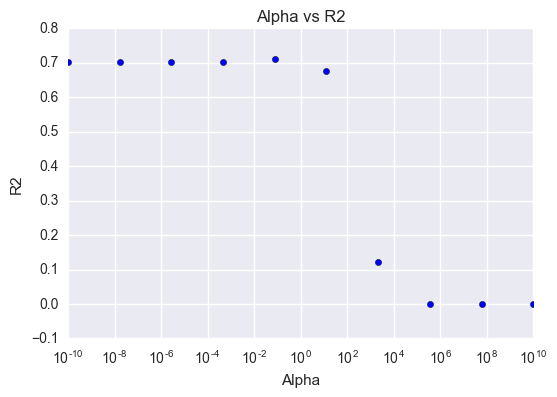

In [186]:
plt.scatter(y=gs_Rid.cv_results_['mean_test_score'],x=np.logspace(start=-10, stop=10, num=10))
plt.xscale('log')
plt.xlim(1e-10,10000000000)
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.title('Alpha vs R2')

There is a clear drop off in R2 as the alpha increase in the Ridge regression, the best paremeter is also in line with that found using the Ridge in the intial modelling, there for I will localize the search around this area. 

In [187]:
Rid=Ridge()
parameters={'alpha':np.logspace(start=-4, stop=1, num=30)}

#After completion, show the final best results and scores
gs_Rid = GridSearchCV(Rid,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Rid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.707326 -   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ........................... alpha=0.0001, score=0.707464 -   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] ........................... alpha=0.0001, score=0.684743 -   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV] ........................... alpha=0.0001, score=0.711635 -   0.0s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV] ........................... alpha=0.0001, score=0.706998 -   0.0s
[CV] alpha=0.000148735210729 .........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s


[CV] ................ alpha=0.000148735210729, score=0.707330 -   0.0s
[CV] alpha=0.000148735210729 .........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV] ................ alpha=0.000148735210729, score=0.707470 -   0.0s
[CV] alpha=0.000148735210729 .........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.1s remaining:    0.0s


[CV] ................ alpha=0.000148735210729, score=0.684747 -   0.0s
[CV] alpha=0.000148735210729 .........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.8s remaining:    0.0s


[CV] ................ alpha=0.000148735210729, score=0.711646 -   0.0s
[CV] alpha=0.000148735210729 .........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.5s remaining:    0.0s


[CV] ................ alpha=0.000148735210729, score=0.707004 -   0.0s
[CV] alpha=0.000221221629107 .........................................
[CV] ................ alpha=0.000221221629107, score=0.707337 -   0.0s
[CV] alpha=0.000221221629107 .........................................
[CV] ................ alpha=0.000221221629107, score=0.707478 -   0.0s
[CV] alpha=0.000221221629107 .........................................
[CV] ................ alpha=0.000221221629107, score=0.684752 -   0.0s
[CV] alpha=0.000221221629107 .........................................
[CV] ................ alpha=0.000221221629107, score=0.711662 -   0.0s
[CV] alpha=0.000221221629107 .........................................
[CV] ................ alpha=0.000221221629107, score=0.707012 -   0.0s
[CV] alpha=0.000329034456231 .........................................
[CV] ................ alpha=0.000329034456231, score=0.707348 -   0.0s
[CV] alpha=0.000329034456231 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-04,   1.48735e-04,   2.21222e-04,   3.29034e-04,
         4.89390e-04,   7.27895e-04,   1.08264e-03,   1.61026e-03,
         2.39503e-03,   3.56225e-03,   5.29832e-03,   7.88046e-03,
         1.17210e-02,   1.74333e-02,   2.59294e-02,   3.85662e-02,
         5....    1.37382e+00,   2.04336e+00,   3.03920e+00,   4.52035e+00,
         6.72336e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [188]:
gs_Rid.best_score_

0.72552318121566406

In [189]:
gs_Rid.best_params_

{'alpha': 1.3738237958832638}

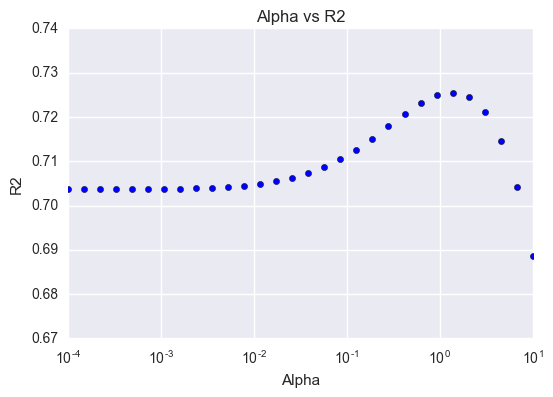

In [191]:
plt.scatter(y=gs_Rid.cv_results_['mean_test_score'],x=np.logspace(start=-4, stop=1, num=30))
plt.xscale('log')
plt.xlim(1e-4,1e1)
plt.xlabel('Alpha')
plt.ylabel('R2')
plt.title('Alpha vs R2')

The chat above again shows a clear optimum value for alpha which will be used going forward, again this can probably be improved upon how ever the difference would be negligble.

### Extra Trees

As the Tree ensemble models take a lot longer to run I will not be able to achieve as high an optimisation with the hyperparameters, I will therefore look for a point where increase the hyperparmeters will only make negligable changes. 

In [163]:
parameters={'n_estimators':[10,50,100,150],
           'min_samples_split':[2,5],
           'max_depth':[None,3,5]}

#After completion, show the final best results and scores
gs_ext = GridSearchCV(ext,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_ext.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] min_samples_split=2, n_estimators=10, max_depth=None ............
[CV]  min_samples_split=2, n_estimators=10, max_depth=None, score=0.619384 -   0.1s
[CV] min_samples_split=2, n_estimators=10, max_depth=None ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, max_depth=None, score=0.706825 -   0.0s
[CV] min_samples_split=2, n_estimators=10, max_depth=None ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.2s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, max_depth=None, score=0.677394 -   0.0s
[CV] min_samples_split=2, n_estimators=10, max_depth=None ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.6s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, max_depth=None, score=0.686610 -   0.0s
[CV] min_samples_split=2, n_estimators=10, max_depth=None ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.2s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, max_depth=None, score=0.687082 -   0.0s
[CV] min_samples_split=2, n_estimators=50, max_depth=None ............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.0s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=50, max_depth=None, score=0.625323 -   0.2s
[CV] min_samples_split=2, n_estimators=50, max_depth=None ............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=50, max_depth=None, score=0.700932 -   0.2s
[CV] min_samples_split=2, n_estimators=50, max_depth=None ............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.1min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=50, max_depth=None, score=0.677729 -   0.1s
[CV] min_samples_split=2, n_estimators=50, max_depth=None ............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.8min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=50, max_depth=None, score=0.687180 -   0.2s
[CV] min_samples_split=2, n_estimators=50, max_depth=None ............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.6min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=50, max_depth=None, score=0.688986 -   0.2s
[CV] min_samples_split=2, n_estimators=100, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=100, max_depth=None, score=0.626038 -   0.3s
[CV] min_samples_split=2, n_estimators=100, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=100, max_depth=None, score=0.703973 -   0.3s
[CV] min_samples_split=2, n_estimators=100, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=100, max_depth=None, score=0.678183 -   0.3s
[CV] min_samples_split=2, n_estimators=100, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=100, max_depth=None, score=0.681943 -   0.3s
[CV] min_samples_split=2, n_estimators=100, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=100, max_depth=None, score=0.687661 -   0.5s
[CV] min_samples_split=2, n_estimators=150, max_depth=None ...........
[CV]  min_samples_split=2, n_estimators=150, max_depth=None, scor

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 59.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 150], 'min_samples_split': [2, 5], 'max_depth': [None, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [169]:
gs_ext.best_score_

0.69210669989823403

In [170]:
gs_ext.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}

In [48]:
ext=ExtraTreesRegressor()
parameters={'n_estimators':[200,400,600,800],
           'min_samples_split':[5,7],
           'max_depth':[None]}

#After completion, show the final best results and scores
gs_ext = GridSearchCV(ext,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_ext.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] min_samples_split=5, n_estimators=200, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=200, max_depth=None, score=0.651047 -   0.3s
[CV] min_samples_split=5, n_estimators=200, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=200, max_depth=None, score=0.722929 -   0.4s
[CV] min_samples_split=5, n_estimators=200, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=200, max_depth=None, score=0.687968 -   0.4s
[CV] min_samples_split=5, n_estimators=200, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.8min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=200, max_depth=None, score=0.689576 -   0.4s
[CV] min_samples_split=5, n_estimators=200, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.5min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=200, max_depth=None, score=0.699798 -   0.4s
[CV] min_samples_split=5, n_estimators=400, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.1min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=400, max_depth=None, score=0.650001 -   0.6s
[CV] min_samples_split=5, n_estimators=400, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 18.0min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=400, max_depth=None, score=0.721636 -   1.7s
[CV] min_samples_split=5, n_estimators=400, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 60.4min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=400, max_depth=None, score=0.688370 -   0.7s
[CV] min_samples_split=5, n_estimators=400, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 66.2min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=400, max_depth=None, score=0.693328 -   0.7s
[CV] min_samples_split=5, n_estimators=400, max_depth=None ...........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 71.6min remaining:    0.0s


[CV]  min_samples_split=5, n_estimators=400, max_depth=None, score=0.700372 -   1.0s
[CV] min_samples_split=5, n_estimators=600, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=600, max_depth=None, score=0.650759 -   1.6s
[CV] min_samples_split=5, n_estimators=600, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=600, max_depth=None, score=0.721521 -   2.4s
[CV] min_samples_split=5, n_estimators=600, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=600, max_depth=None, score=0.688320 -   2.3s
[CV] min_samples_split=5, n_estimators=600, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=600, max_depth=None, score=0.694013 -   1.6s
[CV] min_samples_split=5, n_estimators=600, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=600, max_depth=None, score=0.699728 -   1.4s
[CV] min_samples_split=5, n_estimators=800, max_depth=None ...........
[CV]  min_samples_split=5, n_estimators=800, max_depth=None, sco

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 309.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400, 600, 800], 'min_samples_split': [5, 7], 'max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [49]:
gs_ext.best_score_

0.69254537280310713

In [50]:
gs_ext.best_params_

{'max_depth': None, 'min_samples_split': 7, 'n_estimators': 800}

With the much large hyperparameter search there has been a negligible effect on the best score (only an increase of 0.004), therfore I will not seach any further but will use the best parameters found.

### Random Forest Grid Search

In [172]:
parameters={'n_estimators':[10,50,100],
           'min_samples_split':[2,5]}

#After completion, show the final best results and scores
gs_Rft = GridSearchCV(Rft,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Rft.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_samples_split=2, n_estimators=10 ............................
[CV] ... min_samples_split=2, n_estimators=10, score=0.678414 -   0.1s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=10, score=0.736100 -   0.1s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=10, score=0.689818 -   0.1s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.8s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=10, score=0.735340 -   0.1s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.4s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=10, score=0.711791 -   0.1s
[CV] min_samples_split=2, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.3s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=50, score=0.712273 -   0.3s
[CV] min_samples_split=2, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   59.4s remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=50, score=0.748294 -   0.2s
[CV] min_samples_split=2, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=50, score=0.708391 -   0.2s
[CV] min_samples_split=2, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=50, score=0.739061 -   0.2s
[CV] min_samples_split=2, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.4min remaining:    0.0s


[CV] ... min_samples_split=2, n_estimators=50, score=0.737846 -   0.2s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] .. min_samples_split=2, n_estimators=100, score=0.710783 -   0.3s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] .. min_samples_split=2, n_estimators=100, score=0.746607 -   0.4s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] .. min_samples_split=2, n_estimators=100, score=0.703519 -   0.3s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] .. min_samples_split=2, n_estimators=100, score=0.738942 -   0.3s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] .. min_samples_split=2, n_estimators=100, score=0.732842 -   0.3s
[CV] min_samples_split=5, n_estimators=10 ............................
[CV] ... min_samples_split=5, n_estimators=10, score=0.706384 -   0.1s
[CV] min_samples_split=5, n_estimators=10 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [173]:
gs_Rft.best_score_

0.7326725020026571

In [174]:
gs_Rft.best_params_

{'min_samples_split': 5, 'n_estimators': 100}

As the best score were provided by hyperparmeters at the edge of my search conditions I will extend my search criteria to find the local minimum. 

In [191]:
parameters={'n_estimators':[200,400,600,800],
           'min_samples_split':[3,5,7]}

#After completion, show the final best results and scores
gs_Rft = GridSearchCV(Rft,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Rft.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_samples_split=3, n_estimators=200 ...........................
[CV] .. min_samples_split=3, n_estimators=200, score=0.718198 -   1.0s
[CV] min_samples_split=3, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=200, score=0.748963 -   0.5s
[CV] min_samples_split=3, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=200, score=0.706782 -   0.4s
[CV] min_samples_split=3, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=200, score=0.742958 -   0.5s
[CV] min_samples_split=3, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.6min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=200, score=0.736378 -   0.5s
[CV] min_samples_split=3, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.3min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=400, score=0.716178 -   0.9s
[CV] min_samples_split=3, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 11.4min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=400, score=0.749809 -   0.8s
[CV] min_samples_split=3, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 14.9min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=400, score=0.707769 -   0.8s
[CV] min_samples_split=3, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 18.3min remaining:    0.0s


[CV] .. min_samples_split=3, n_estimators=400, score=0.742338 -   1.0s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 21.8min remaining:    0.0s


[CV] min_samples_split=3, n_estimators=400 ...........................
[CV] .. min_samples_split=3, n_estimators=400, score=0.736536 -   1.4s
[CV] min_samples_split=3, n_estimators=600 ...........................
[CV] .. min_samples_split=3, n_estimators=600, score=0.717374 -   2.1s
[CV] min_samples_split=3, n_estimators=600 ...........................
[CV] .. min_samples_split=3, n_estimators=600, score=0.749898 -   2.3s
[CV] min_samples_split=3, n_estimators=600 ...........................
[CV] .. min_samples_split=3, n_estimators=600, score=0.707262 -   1.4s
[CV] min_samples_split=3, n_estimators=600 ...........................
[CV] .. min_samples_split=3, n_estimators=600, score=0.742845 -   1.3s
[CV] min_samples_split=3, n_estimators=600 ...........................
[CV] .. min_samples_split=3, n_estimators=600, score=0.739087 -   1.3s
[CV] min_samples_split=3, n_estimators=800 ...........................
[CV] .. min_samples_split=3, n_estimators=800, score=0.717155 -   3.3s
[CV] m

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 346.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400, 600, 800], 'min_samples_split': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [192]:
gs_Rft.best_score_

0.73280112367741967

In [193]:
gs_Rft.best_params_

{'min_samples_split': 5, 'n_estimators': 200}

In [197]:
gs_Rft.grid_scores_

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.73065, std: 0.01578, params: {'min_samples_split': 3, 'n_estimators': 200},
 mean: 0.73052, std: 0.01595, params: {'min_samples_split': 3, 'n_estimators': 400},
 mean: 0.73129, std: 0.01620, params: {'min_samples_split': 3, 'n_estimators': 600},
 mean: 0.73121, std: 0.01635, params: {'min_samples_split': 3, 'n_estimators': 800},
 mean: 0.73280, std: 0.01649, params: {'min_samples_split': 5, 'n_estimators': 200},
 mean: 0.73217, std: 0.01633, params: {'min_samples_split': 5, 'n_estimators': 400},
 mean: 0.73248, std: 0.01700, params: {'min_samples_split': 5, 'n_estimators': 600},
 mean: 0.73166, std: 0.01687, params: {'min_samples_split': 5, 'n_estimators': 800},
 mean: 0.73106, std: 0.01725, params: {'min_samples_split': 7, 'n_estimators': 200},
 mean: 0.73242, std: 0.01705, params: {'min_samples_split': 7, 'n_estimators': 400},
 mean: 0.73253, std: 0.01684, params: {'min_samples_split': 7, 'n_estimators': 600},
 mean: 0.73128, std: 0.01698, params: {'min_samples_split': 7, 'n

We can see from the restults above that the r2 and standard deviation do not vary significantly across all of the parameters, therefore I will take the best score parameters as this also happens to be with the lowest amount of estimators reducing the computation time.

### K-Nearest Neighbours Grid Search

In [165]:
parameters={'n_neighbors':[2,5,10,15,20,25]}

gs_knn = GridSearchCV(knn,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=2 ...................................................
[CV] .......................... n_neighbors=2, score=0.588195 -  20.0s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] .......................... n_neighbors=2, score=0.468494 -  16.6s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] .......................... n_neighbors=2, score=0.567529 -  18.0s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV] .......................... n_neighbors=2, score=0.535043 -  17.4s
[CV] n_neighbors=2 ...................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.5min remaining:    0.0s


[CV] .......................... n_neighbors=2, score=0.552314 -  18.7s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s


[CV] .......................... n_neighbors=5, score=0.606559 -  20.2s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.5min remaining:    0.0s


[CV] .......................... n_neighbors=5, score=0.546856 -  19.1s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.2min remaining:    0.0s


[CV] .......................... n_neighbors=5, score=0.564643 -  25.1s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.3min remaining:    0.0s


[CV] .......................... n_neighbors=5, score=0.581346 -  21.7s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.1min remaining:    0.0s


[CV] .......................... n_neighbors=5, score=0.587187 -  20.4s
[CV] n_neighbors=10 ..................................................
[CV] ......................... n_neighbors=10, score=0.575229 -  23.3s
[CV] n_neighbors=10 ..................................................
[CV] ......................... n_neighbors=10, score=0.530263 -  28.6s
[CV] n_neighbors=10 ..................................................
[CV] ......................... n_neighbors=10, score=0.533526 -  22.7s
[CV] n_neighbors=10 ..................................................
[CV] ......................... n_neighbors=10, score=0.558951 -  24.1s
[CV] n_neighbors=10 ..................................................
[CV] ......................... n_neighbors=10, score=0.565937 -  25.3s
[CV] n_neighbors=15 ..................................................
[CV] ......................... n_neighbors=15, score=0.536425 -  24.3s
[CV] n_neighbors=15 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 57.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [2, 5, 10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [166]:
gs_knn.best_score_

0.57731637571620664

In [168]:
gs_knn.best_params_

{'n_neighbors': 5}

Even with some tuning the KNN model has still performed poorly in comparison to the others tested.

### Gradient Boost Grid Search

Again due to the processing time I will only continue to tune the model when the r2 changes are significant.

In [175]:
parameters={'n_estimators':[100,150],
           'min_samples_split':[2,5],
           'min_samples_leaf':[1,3,5]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=1, score=0.502387 -   0.1s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=1, score=0.512273 -   0.0s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.1s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=1, score=0.480292 -   0.0s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.4s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=1, score=0.504226 -   0.0s
[CV] min_samples_split=2, n_estimators=100, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.2s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=100, min_samples_leaf=1, score=0.530138 -   0.0s
[CV] min_samples_split=2, n_estimators=150, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=150, min_samples_leaf=1, score=0.562260 -   0.0s
[CV] min_samples_split=2, n_estimators=150, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=150, min_samples_leaf=1, score=0.575755 -   0.0s
[CV] min_samples_split=2, n_estimators=150, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=150, min_samples_leaf=1, score=0.543983 -   0.0s
[CV] min_samples_split=2, n_estimators=150, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=150, min_samples_leaf=1, score=0.576119 -   0.0s
[CV] min_samples_split=2, n_estimators=150, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=150, min_samples_leaf=1, score=0.595953 -   0.0s
[CV] min_samples_split=5, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=100, min_samples_leaf=1, score=0.504024 -   0.1s
[CV] min_samples_split=5, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=100, min_samples_leaf=1, score=0.511906 -   0.0s
[CV] min_samples_split=5, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=100, min_samples_leaf=1, score=0.478636 -   0.0s
[CV] min_samples_split=5, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=100, min_samples_leaf=1, score=0.505830 -   0.1s
[CV] min_samples_split=5, n_estimators=100, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=100, min_samples_leaf=1, score=0.528553 -   0.1s
[CV] min_samples_split=5, n_estimators=150, min_samples_leaf=1 .......
[CV]  min_samples_split=5, n_estimators=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 15.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [176]:
gs_Gra.best_score_

0.57080992681427234

In [177]:
gs_Gra.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

In [178]:
parameters={'n_estimators':[125,150,175],
           'min_samples_split':[2,5]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] min_samples_split=2, n_estimators=125 ...........................
[CV] .. min_samples_split=2, n_estimators=125, score=0.534027 -   0.0s
[CV] min_samples_split=2, n_estimators=125 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=125, score=0.549564 -   0.1s
[CV] min_samples_split=2, n_estimators=125 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.4s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=125, score=0.514864 -   0.0s
[CV] min_samples_split=2, n_estimators=125 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.3s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=125, score=0.543984 -   0.1s
[CV] min_samples_split=2, n_estimators=125 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=125, score=0.565987 -   0.0s
[CV] min_samples_split=2, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=150, score=0.563241 -   0.0s
[CV] min_samples_split=2, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=150, score=0.575979 -   0.1s
[CV] min_samples_split=2, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.9min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=150, score=0.544665 -   0.1s
[CV] min_samples_split=2, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=150, score=0.575727 -   0.1s
[CV] min_samples_split=2, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.6min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=150, score=0.596046 -   0.1s
[CV] min_samples_split=2, n_estimators=175 ...........................
[CV] .. min_samples_split=2, n_estimators=175, score=0.589234 -   0.0s
[CV] min_samples_split=2, n_estimators=175 ...........................
[CV] .. min_samples_split=2, n_estimators=175, score=0.600413 -   0.0s
[CV] min_samples_split=2, n_estimators=175 ...........................
[CV] .. min_samples_split=2, n_estimators=175, score=0.566304 -   0.1s
[CV] min_samples_split=2, n_estimators=175 ...........................
[CV] .. min_samples_split=2, n_estimators=175, score=0.599072 -   0.0s
[CV] min_samples_split=2, n_estimators=175 ...........................
[CV] .. min_samples_split=2, n_estimators=175, score=0.616334 -   0.0s
[CV] min_samples_split=5, n_estimators=125 ...........................
[CV] .. min_samples_split=5, n_estimators=125, score=0.537063 -   0.0s
[CV] min_samples_split=5, n_estimators=125 ...........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [125, 150, 175], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [180]:
gs_Gra.best_score_

0.59426796170318286

In [179]:
gs_Gra.best_params_

{'min_samples_split': 2, 'n_estimators': 175}

Even a small increase in estimators have changed the score significantly.

In [181]:
parameters={'n_estimators':[200,300,400],
           'min_samples_split':[2]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] min_samples_split=2, n_estimators=200 ...........................
[CV] .. min_samples_split=2, n_estimators=200, score=0.603051 -   0.1s
[CV] min_samples_split=2, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=200, score=0.619625 -   0.1s
[CV] min_samples_split=2, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.6s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=200, score=0.585048 -   0.0s
[CV] min_samples_split=2, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=200, score=0.620698 -   0.1s
[CV] min_samples_split=2, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=200, score=0.633516 -   0.0s
[CV] min_samples_split=2, n_estimators=300 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=300, score=0.662798 -   0.0s
[CV] min_samples_split=2, n_estimators=300 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=300, score=0.666291 -   0.1s
[CV] min_samples_split=2, n_estimators=300 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=300, score=0.635121 -   0.0s
[CV] min_samples_split=2, n_estimators=300 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.7min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=300, score=0.669240 -   0.0s
[CV] min_samples_split=2, n_estimators=300 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.2min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=300, score=0.679803 -   0.0s
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.686481 -   0.0s
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.688869 -   0.0s
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.662728 -   0.0s
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.698387 -   0.1s
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.705421 -   0.1s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300, 400], 'min_samples_split': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [182]:
gs_Gra.best_score_

0.68837375371774245

In [183]:
gs_Gra.best_params_

{'min_samples_split': 2, 'n_estimators': 400}

There are has been a large improvement in score with the increased estimators I will increase them further to see when the r2 starts to tail off.


In [184]:
parameters={'n_estimators':[400,600,800],
           'min_samples_split':[2]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] min_samples_split=2, n_estimators=400 ...........................
[CV] .. min_samples_split=2, n_estimators=400, score=0.685663 -   0.1s
[CV] min_samples_split=2, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.3s remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=400, score=0.692650 -   0.1s
[CV] min_samples_split=2, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=400, score=0.663321 -   0.1s
[CV] min_samples_split=2, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=400, score=0.697985 -   0.1s
[CV] min_samples_split=2, n_estimators=400 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.0min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=400, score=0.703845 -   0.1s
[CV] min_samples_split=2, n_estimators=600 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=600, score=0.710898 -   0.1s
[CV] min_samples_split=2, n_estimators=600 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.0min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=600, score=0.722529 -   0.1s
[CV] min_samples_split=2, n_estimators=600 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.0min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=600, score=0.690254 -   0.1s
[CV] min_samples_split=2, n_estimators=600 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.1min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=600, score=0.727380 -   0.1s
[CV] min_samples_split=2, n_estimators=600 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.2min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=600, score=0.730660 -   0.1s
[CV] min_samples_split=2, n_estimators=800 ...........................
[CV] .. min_samples_split=2, n_estimators=800, score=0.720501 -   0.1s
[CV] min_samples_split=2, n_estimators=800 ...........................
[CV] .. min_samples_split=2, n_estimators=800, score=0.732256 -   0.1s
[CV] min_samples_split=2, n_estimators=800 ...........................
[CV] .. min_samples_split=2, n_estimators=800, score=0.702593 -   0.1s
[CV] min_samples_split=2, n_estimators=800 ...........................
[CV] .. min_samples_split=2, n_estimators=800, score=0.740419 -   0.2s
[CV] min_samples_split=2, n_estimators=800 ...........................
[CV] .. min_samples_split=2, n_estimators=800, score=0.742377 -   0.1s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 16.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [400, 600, 800], 'min_samples_split': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [185]:
gs_Gra.best_score_

0.7276258048689358

In [186]:
gs_Gra.best_params_

{'min_samples_split': 2, 'n_estimators': 800}

The increase this time has not been as signifcant but still has increased by 0.4, I will widen the search further.

In [187]:
parameters={'n_estimators':[900,1000,1100],
           'min_samples_split':[2]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] min_samples_split=2, n_estimators=900 ...........................
[CV] .. min_samples_split=2, n_estimators=900, score=0.724919 -   0.1s
[CV] min_samples_split=2, n_estimators=900 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=900, score=0.743322 -   0.1s
[CV] min_samples_split=2, n_estimators=900 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=900, score=0.709192 -   0.1s
[CV] min_samples_split=2, n_estimators=900 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=900, score=0.744374 -   0.1s
[CV] min_samples_split=2, n_estimators=900 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.3min remaining:    0.0s


[CV] .. min_samples_split=2, n_estimators=900, score=0.743939 -   0.1s
[CV] min_samples_split=2, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.9min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1000, score=0.727163 -   0.1s
[CV] min_samples_split=2, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.6min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1000, score=0.744172 -   0.2s
[CV] min_samples_split=2, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.4min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1000, score=0.709924 -   0.1s
[CV] min_samples_split=2, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.1min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1000, score=0.746053 -   0.2s
[CV] min_samples_split=2, n_estimators=1000 ..........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.0min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1000, score=0.748693 -   0.1s
[CV] min_samples_split=2, n_estimators=1100 ..........................
[CV] . min_samples_split=2, n_estimators=1100, score=0.728861 -   0.2s
[CV] min_samples_split=2, n_estimators=1100 ..........................
[CV] . min_samples_split=2, n_estimators=1100, score=0.744150 -   0.1s
[CV] min_samples_split=2, n_estimators=1100 ..........................
[CV] . min_samples_split=2, n_estimators=1100, score=0.712956 -   0.2s
[CV] min_samples_split=2, n_estimators=1100 ..........................
[CV] . min_samples_split=2, n_estimators=1100, score=0.749063 -   0.2s
[CV] min_samples_split=2, n_estimators=1100 ..........................
[CV] . min_samples_split=2, n_estimators=1100, score=0.750757 -   0.1s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 27.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [900, 1000, 1100], 'min_samples_split': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [188]:
gs_Gra.best_score_

0.73715412415541348

In [189]:
gs_Gra.best_params_

{'min_samples_split': 2, 'n_estimators': 1100}

I will widen the search one final time to see if I can improve upon this score as the hypeparameters continue to be at the boarder of my search.

In [63]:
Gra=GradientBoostingRegressor()
parameters={'n_estimators':[1200,1300],
           'min_samples_split':[2,5]}

gs_Gra = GridSearchCV(Gra,
                  param_grid=parameters, 
                  verbose=10, 
                  cv=5, 
                  scoring='r2')
gs_Gra.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] min_samples_split=2, n_estimators=1200 ..........................
[CV] . min_samples_split=2, n_estimators=1200, score=0.734341 -   0.1s
[CV] min_samples_split=2, n_estimators=1200 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1200, score=0.748939 -   0.1s
[CV] min_samples_split=2, n_estimators=1200 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1200, score=0.720940 -   0.1s
[CV] min_samples_split=2, n_estimators=1200 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.5min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1200, score=0.744356 -   0.1s
[CV] min_samples_split=2, n_estimators=1200 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.0min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1200, score=0.742312 -   0.2s
[CV] min_samples_split=2, n_estimators=1300 ..........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.6min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1300, score=0.734400 -   0.1s
[CV] min_samples_split=2, n_estimators=1300 ..........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.3min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1300, score=0.748684 -   0.1s
[CV] min_samples_split=2, n_estimators=1300 ..........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.2min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1300, score=0.723952 -   0.2s
[CV] min_samples_split=2, n_estimators=1300 ..........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.0min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1300, score=0.742589 -   0.1s
[CV] min_samples_split=2, n_estimators=1300 ..........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.7min remaining:    0.0s


[CV] . min_samples_split=2, n_estimators=1300, score=0.745272 -   0.1s
[CV] min_samples_split=5, n_estimators=1200 ..........................
[CV] . min_samples_split=5, n_estimators=1200, score=0.736121 -   0.1s
[CV] min_samples_split=5, n_estimators=1200 ..........................
[CV] . min_samples_split=5, n_estimators=1200, score=0.745003 -   0.1s
[CV] min_samples_split=5, n_estimators=1200 ..........................
[CV] . min_samples_split=5, n_estimators=1200, score=0.724758 -   0.1s
[CV] min_samples_split=5, n_estimators=1200 ..........................
[CV] . min_samples_split=5, n_estimators=1200, score=0.744607 -   0.1s
[CV] min_samples_split=5, n_estimators=1200 ..........................
[CV] . min_samples_split=5, n_estimators=1200, score=0.743434 -   0.1s
[CV] min_samples_split=5, n_estimators=1300 ..........................
[CV] . min_samples_split=5, n_estimators=1300, score=0.736461 -   0.1s
[CV] min_samples_split=5, n_estimators=1300 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 31.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1200, 1300], 'min_samples_split': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=10)

In [68]:
gs_Gra.best_score_

0.73989538957968082

In [69]:
gs_Gra.best_params_

{'min_samples_split': 5, 'n_estimators': 1300}

Again the best parameters are at the edge of my search criteria however the improvements of r2 are note significant enough to warrent further searching at this stage, it is however the best model looked at.

## Final Models and Model Ensembles

Using the grid search I have found that gradient boosting has provided the best results, however this is not by such a significant margin that it may be improved by an ensemble of models. I will now rerun the base models using the optimal hyperparameters found above. I will then use the resulting y-predicted values to see if I can improve on the results with an ensemble of models.

### LassoCV

In [18]:
Fin_R2_Train=[]
Fin_R2_Test=[]

In [74]:
Las_Fin=LassoCV(cv=5,alphas=[0.025929437974046669])
Las_Fin_model=Las_Fin.fit(X_train,y_train)


print 'R2:',Las_Fin_model.score(X_train,y_train)


Las_Fin_y_pred=Las_Fin_model.predict(X_test)

R2: 0.765910463366


In [75]:
Las_Fin_y_pred_train=Las_Fin_model.predict(X_train)
print 'Test R2:',r2_score(y_test,Las_Fin_y_pred)
Fin_R2_Train.append(Las_Fin_model.score(X_train,y_train))
Fin_R2_Test.append(r2_score(y_test,Las_Fin_y_pred))

Test R2: 0.748491115


### RidgeCV

In [29]:
Rid_Fin=RidgeCV(cv=5,alphas=[1.3738237958832638])
Rid_Fin_model=Rid_Fin.fit(X_train,y_train)


print 'R2:',Rid_Fin_model.score(X_train,y_train)

Rid_Fin_y_pred=Rid_Fin_model.predict(X_test)

R2: 0.768369543731


In [30]:
Rid_Fin_y_pred_train=Rid_Fin_model.predict(X_train)
print 'Test R2:',r2_score(y_test,Rid_Fin_y_pred)
Fin_R2_Train.append(Rid_Fin_model.score(X_train,y_train))
Fin_R2_Test.append(r2_score(y_test,Rid_Fin_y_pred))

Test R2: 0.747276864474


### Gradient Boost

In [16]:
Gra_Fin=GradientBoostingRegressor(min_samples_split= 5, n_estimators=1300)
Gra_Fin_model=Gra_Fin.fit(X_train,y_train)


print 'R2:',Gra_Fin_model.score(X_train,y_train)

Gra_Fin_y_pred=Gra_Fin_model.predict(X_test)

R2: 0.847887734063


In [19]:
Gra_Fin_y_pred_train=Gra_Fin_model.predict(X_train)
print 'Test R2:',r2_score(y_test,Gra_Fin_y_pred)
Fin_R2_Train.append(Gra_Fin_model.score(X_train,y_train))
Fin_R2_Test.append(r2_score(y_test,Gra_Fin_y_pred))

Test R2: 0.77481656158


### Random Forest

In [80]:
Rft_Fin=RandomForestRegressor(n_estimators=200, min_samples_split=5)
Rft_Fin_model=Rft_Fin.fit(X_train,y_train)

print 'R2:',Rft_Fin_model.score(X_train,y_train)

Rft_Fin_y_pred=Rft_Fin_model.predict(X_test)

R2: 0.89630755704


In [81]:
Rft_Fin_y_pred_train=Rft_Fin_model.predict(X_train)
print 'Test R2:',r2_score(y_test,Rft_Fin_y_pred)
Fin_R2_Train.append(Rft_Fin_model.score(X_train,y_train))
Fin_R2_Test.append(r2_score(y_test,Rft_Fin_y_pred))

Test R2: 0.743034285213


### Extra Trees

In [82]:
Ext_Fin=ExtraTreesRegressor(min_samples_split= 7, n_estimators= 800)
Ext_Fin_model=Ext_Fin.fit(X_train,y_train)

print 'R2:',Ext_Fin_model.score(X_train,y_train)

Ext_Fin_y_pred=Ext_Fin_model.predict(X_test)

R2: 0.904690475719


In [83]:
Ext_Fin_y_pred_train=Ext_Fin_model.predict(X_train)
print 'Test R2:',r2_score(y_test,Ext_Fin_y_pred)
Fin_R2_Train.append(Ext_Fin_model.score(X_train,y_train))
Fin_R2_Test.append(r2_score(y_test,Ext_Fin_y_pred))

Test R2: 0.711630475988


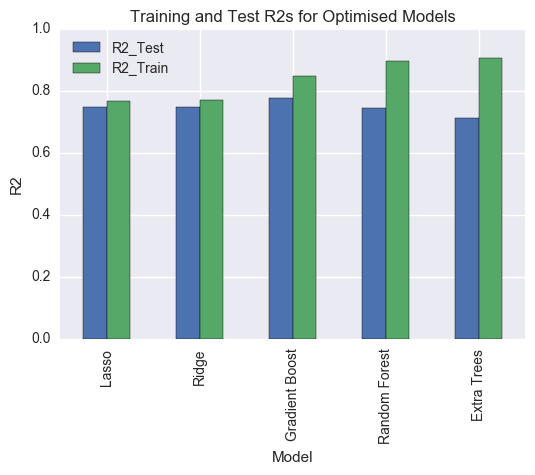

In [84]:
Final_Results=pd.DataFrame({'R2_Train':Fin_R2_Train,
                            'R2_Test':Fin_R2_Test,
                            'Model':['Lasso','Ridge','Gradient Boost','Random Forest','Extra Trees']})
Final_Results.plot(kind='bar',x='Model')
plt.ylabel('R2')
plt.title('Training and Test R2s for Optimised Models')

Although the tree models have produced high training r2s this has proved to be overfitting by the gridsearch/cross-validation. As found with the gridsearch, gradient boosting has performed the best of the models using the optimised hyperparameters. I will now see if a model ensemble can make any improvments.

In [85]:
Fin_Pred_train=pd.DataFrame({'Lasso':Las_Fin_y_pred_train,
                       'Ridge':Rid_Fin_y_pred_train,
                       'Random':Rft_Fin_y_pred_train,
                       'Ext':Ext_Fin_y_pred_train,
                       'Grad':Gra_Fin_y_pred_train})

In [86]:
Fin_Pred=pd.DataFrame({'Lasso':Las_Fin_y_pred,
                       'Ridge':Rid_Fin_y_pred,
                       'Random':Rft_Fin_y_pred,
                       'Ext':Ext_Fin_y_pred,
                       'Grad':Gra_Fin_y_pred})

### Lasso Ensemble of All Models

In [87]:
Las_Ens=LassoCV(cv=5)
Las_Ens_Model=Las_Ens.fit(Fin_Pred_train,y_train)
print 'R2:',Las_Ens_Model.score(Fin_Pred_train,y_train)

R2: 0.910033311583


In [88]:
Las_Ens_Model.coef_

array([ 0.55237898,  0.20389594, -0.196033  ,  0.46335017, -0.        ])

In [89]:
Output_Pred=Las_Ens_Model.predict(Fin_Pred)
print 'R2:',r2_score(y_test,Output_Pred)

R2: 0.730490889162


## Manual Ensemble of results of 4 best models

In [91]:
print 'Train R2:',r2_score(y_train,((Las_Fin_y_pred_train+Rid_Fin_y_pred_train+Rft_Fin_y_pred_train+Gra_Fin_y_pred_train)/4))
print 'Test R2:',r2_score(y_test,((Las_Fin_y_pred+Rid_Fin_y_pred+Rft_Fin_y_pred+Gra_Fin_y_pred)/4))

Train R2: 0.839037137337
Test R2: 0.776468685973


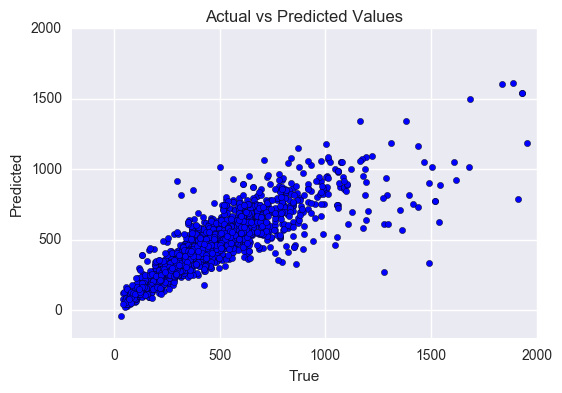

In [92]:
ploty(y_test,((Las_Fin_y_pred+Rid_Fin_y_pred+Rft_Fin_y_pred+Gra_Fin_y_pred)/4))

Although this ensemble has improved slightly on the test r2 score, this is not significant enough to overcome the drop in training r2, it is likely that this mode is just suited to the specific test data set.

## Final Model

Neither of the ensembles have performed better then the Gradient Boosted model, therefore would not be implemented. Below is the final Gradiant Boosted result, as with some of the earlier Lasso and Ridge models, there seem to be some results close to or below 0. I will therefore add a manual rule stating that anything below £30 is set to £30 as this tends to be the minimum price at these retailers.

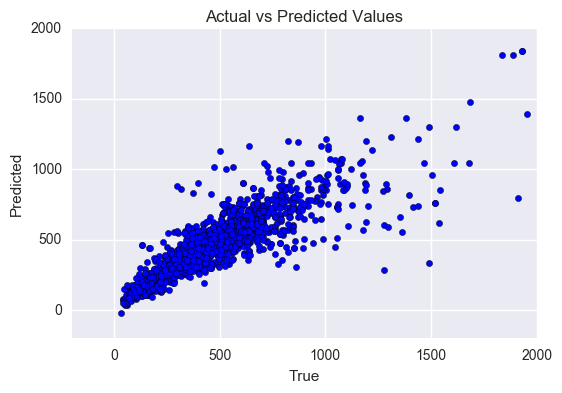

In [93]:
ploty(y_test,Gra_Fin_y_pred)

In [20]:
## Modifying the final results so that all values below 30 are set to 30.
Mod_Gra_Test=Gra_Fin_y_pred.copy()
Mod_Gra_Train=Gra_Fin_y_pred_train.copy()
Mod_Gra_Test[Mod_Gra_Test<30]=30
Mod_Gra_Train[Mod_Gra_Train<30]=30

Test R2: 0.847899096291
MSE: 9154.60004112


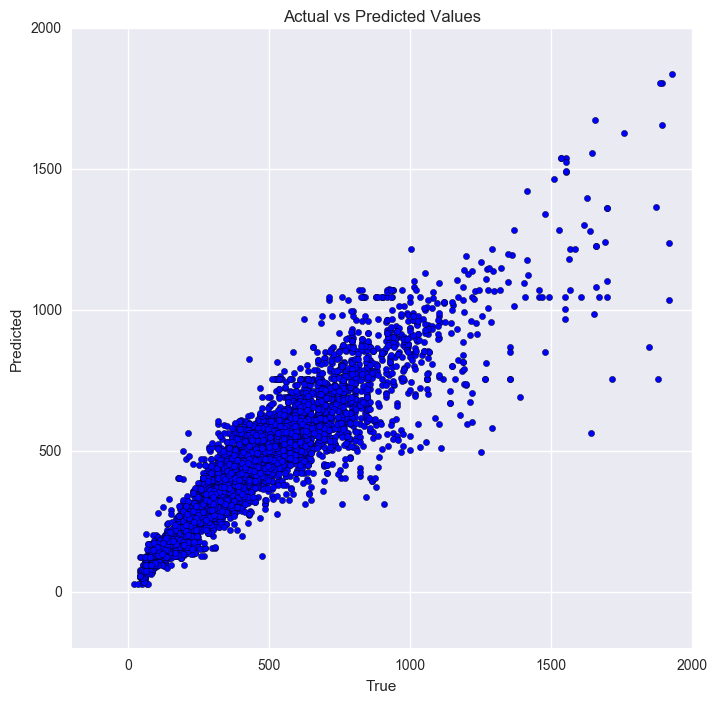

In [28]:
plt.figure(figsize=(8,8))
ploty(y_train,Mod_Gra_Train)
print 'Test R2:',r2_score(y_train,Mod_Gra_Train)
print 'MSE:',mean_squared_error(y_train,Mod_Gra_Train)

Test R2: 0.774833008197
MSE: 13647.7121146


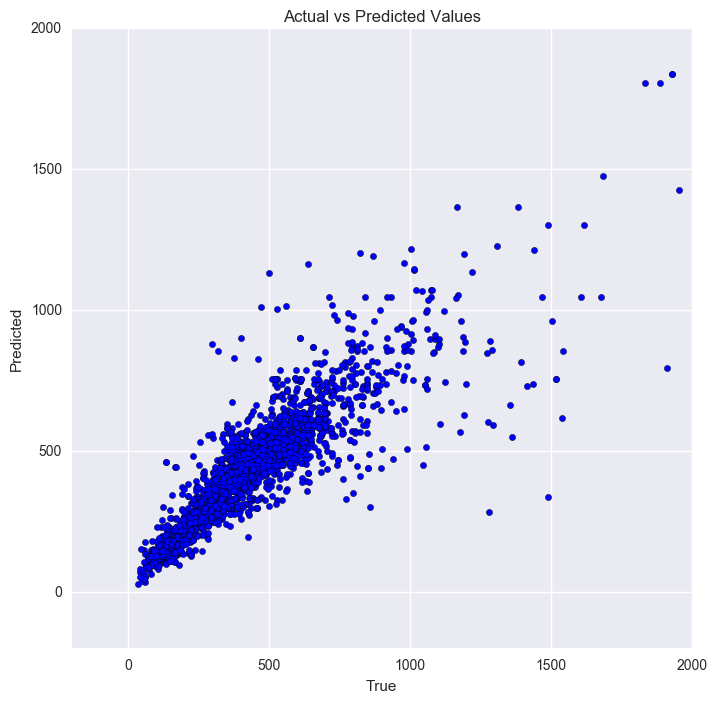

In [27]:
plt.figure(figsize=(8,8))
ploty(y_test,Mod_Gra_Test)
print 'Test R2:',r2_score(y_test,Mod_Gra_Test)
print 'MSE:',mean_squared_error(y_test,Mod_Gra_Test)

## Coefficients

In [35]:
Feat_Ceoff=pd.DataFrame(data={'Coeff':Rid_Fin_model.coef_,'Feature':X_train.columns})

In [40]:
Feat_Ceoff[Feat_Ceoff['Feature'].str.contains("retailer")].sort_values(by='Coeff',ascending=False)

,Coeff,Feature
120,94.114625,retailer_Saks_Fifth_Avenue
116,-1.408780,retailer_Farfetch
119,-15.878255,retailer_Net_A_Porter
118,-35.493999,retailer_Matches_Fashion
117,-41.333591,retailer_Harrods


The coefficents for each of the retailers tend to match those prediceted in the EDA, with Saks being by far the most expensive retailer and Harrods the cheapest.

In [43]:
Feat_Ceoff[Feat_Ceoff['Feature'].str.contains('brand')].sort_values(by='Coeff',ascending=False).head()

,Coeff,Feature
0,981.920480,brand_a diciannoveventitre
16,496.870661,brand_berluti
51,474.401169,brand_guidi
57,469.332477,brand_john lobb
52,432.043158,brand_hender scheme


The top three coffificents for the brands also mirror those found in the EDA.

In [44]:
Feat_Ceoff[Feat_Ceoff['Feature'].str.contains('brand')].sort_values(by='Coeff',ascending=True).head()

,Coeff,Feature
107,-384.112157,brand_toms
108,-383.734860,brand_ugg
27,-317.608507,brand_cole haan
103,-306.327857,brand_timberland
29,-284.836378,brand_converse


In [45]:
Feat_Ceoff[~Feat_Ceoff['Feature'].str.contains('brand')].sort_values(by='Coeff',ascending=False).head()

,Coeff,Feature
188,548.342407,beach
290,273.349049,crystal
408,268.094116,goodyear
772,264.792745,swarovski
499,244.710281,lizard


In [46]:
Feat_Ceoff[~Feat_Ceoff['Feature'].str.contains('brand')].sort_values(by='Coeff',ascending=True).head()

,Coeff,Feature
801,-316.964931,trees
495,-240.028085,levah
800,-234.641057,travel
366,-215.370515,flip
674,-159.198844,reverse


In [53]:
X_train.beach.sum()

1

It is interesting to see what descriptive words tend to relate to lower and higher priced shoes, unsuprisingly flip is has a very low coefficicent as I imagine this relates to flip flops which will always be priced quite lowly. The higher descriptive coefficients seem to relate to materials more such as 'crystal', and 'lizard'. I suspect that the 'goodyear' and 'beach' are not common words (as displayed above) but associated with singular or a couple of high value shoes, so these may be a bit skewed.

# Executive Summary and Conclusion

I achieved a r2 score of 0.77 on untested data which is above my target using a gradient boosting model. In order to do so I have removed values of over £2000 from the dataset as this tended to have large outliers which caused the MSE to rise significantly. The model has been tuned, however I think that an increase in estimators and min samples split, amoung other hyper-parameter changes could improve the result further, but at this point I do not think it would be significant. 

After looking at the coefficients there are a number of large and small coefficients that occur once in the data set, I believe this does not paint an accurate picture, and therefore on further work would place a minumum number of occurances on words that are found in the data set for them to be used at features. 

I had to implement a manual rule for low prediced prices, as a lot of the models produced negitive values or values that would never be found on the related websites. This is an acceptible modfication/assumption to make.

The next steps of this piece of work are to use the scraping scripts to read more data and improve the model further, this data can be used to test the current models, and improve them. I would also like to introduce dominant colours as computed in the notebook ***Image_Features.ipynb*** into the model to see if there is an impact on colour on price.

The model could also be pickled so that it could be used in a web based interface that would allow users to enter a string of words and predict the price of a given shoe, this could be used in conjunction with the image recognition.